In [1]:
# import utility libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset
from geojson import FeatureCollection, Polygon, Feature, dump
%matplotlib inline

# import machine learning tools
from keras.models import model_from_json

# import functions and classese for use
from util import plot_list_in_2D, reformat_y, plot_compare_map, scale_data, eval_regressor_model, eval_classifier_model
from nn_input import NN_Input

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN not available)


# Classifier model using tmin as the only feature

In [216]:
folder = '/home/ubuntu/dataset/'
image_paths = []
n_clusters = 8

models = {}
df_cluster = None

for cluster in xrange(n_clusters):
    json_file = '/home/ubuntu/fall-foliage-finder/models/tmin/model_architecture_'+str(cluster)+'.json'
    weights_file = '/home/ubuntu/fall-foliage-finder/models/tmin/model_weights_'+str(cluster)+'.h5'
    
    sgd = SGD()
    models[cluster] = model_from_json(open(json_file).read())
    models[cluster].load_weights(weights_file)
    models[cluster].compile(loss='categorical_crossentropy',
                              optimizer=sgd,
                              metrics=['accuracy'])
    
    df_subset = pd.read_table('/home/ubuntu/fall-foliage-finder/models/tmin/cluster_list_'+str(cluster)+'.txt',
                             delimiter=' ', names = ['xs', 'ys'])
    df_subset['cluster_num'] = np.ones(len(df_subset), dtype=int)*cluster
    df_cluster = pd.concat((df_cluster, df_subset))
    
df_scaling = pd.read_table('/home/ubuntu/fall-foliage-finder/models/tmin/scaling_weights.txt', delimiter=' ')

In [217]:
nn = NN_Input(predict=2, history=5, box=5, random_seed=42)
nn.load_labels(folder+'sign.label.nc', 'Band1')

f_paths = ['all.mean.of.Tmin.nc', 'all.mean.of.Tmin.nc']
variables = ['Tmin', 'Tmin']
names = ['mean_tmin_history', 'mean_tmin_forecast']
feature_types = ['history_time_series', 'forecast_time_series']

for f_path, v, n, feature_type in zip(f_paths, variables, names, feature_types):
    nn.load_features(folder+f_path, v, n, feature_type)

In [218]:
threshold = 0.5
res = 0.0625/2
total_output = {}

for timepoint in xrange(300, 301):
    # print 'for timepoint', timepoint
    ids, y_true, y_predict = [], [], []
    
    for cluster, model in models.iteritems():
        # print 'for cluster', cluster
        subset = df_cluster[df_cluster.cluster_num == cluster][['xs', 'ys']].values
        id_test, y_test, X_map_test = nn.select(t=timepoint, subset=subset)
        y_test = reformat_y(y_test)
        X_test = scale_data(X_map_test, df_scaling.iloc[cluster]['mean'], df_scaling.iloc[cluster]['std'])
        test_predict = model.predict(X_test)
        if ids == []:
            ids = id_test
            y_true = y_test
            y_predict = test_predict
        else:
            ids = np.vstack((ids, id_test))
            y_true = np.vstack((y_true, y_test))
            y_predict = np.vstack((y_predict, test_predict))
            
    timestamp = nn.times[(ids[0,0]).astype(int)]
    print timestamp
    xs = nn.lons[(ids[:,2]).astype(int)]
    ys = nn.lats[(ids[:,1]).astype(int)]
    
#     features=[]
#     for x, y, val_true, val_predict in zip(xs, ys, y_true[:,0], y_predict[:,0]):
#         poly = Polygon([[(x-res, y-res), (x-res, y+res), (x+res, y+res), (x+res, y-res), (x-res, y-res)]])
#         predict_class = int(val_predict*10)
#         features.append(Feature(geometry=poly, properties={"true": float(val_true), "predict": float(predict_class)}))
#     fc = FeatureCollection(features)
    
#     path = plot_diff_map(xs, ys, y_true[:,0], (y_predict[:,0]>threshold), timestamp=timestamp, s=1)
#     image_paths.append(path)
    
    index = pd.MultiIndex.from_tuples(list(zip(xs, ys)), names=['lon', 'lat'])
    s = pd.Series((y_true[:,0]-(y_predict[:,0]>threshold)), index=index)
    total_output[timestamp] = s
    
#     with open(folder+'output/'+str(int(timestamp))+'.geojson', 'w') as outfile:
#         dump(fc, outfile)

/home/ubuntu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


(205477, 3)
(205477, 2)
(205477, 2)
20090309.5


In [105]:
df_diff = pd.DataFrame(total_output).T
df_diff['month'] = [int(str(x)[4:6]) for x in df_diff.index.values]
df_diff_month = df_diff.groupby('month').mean().T

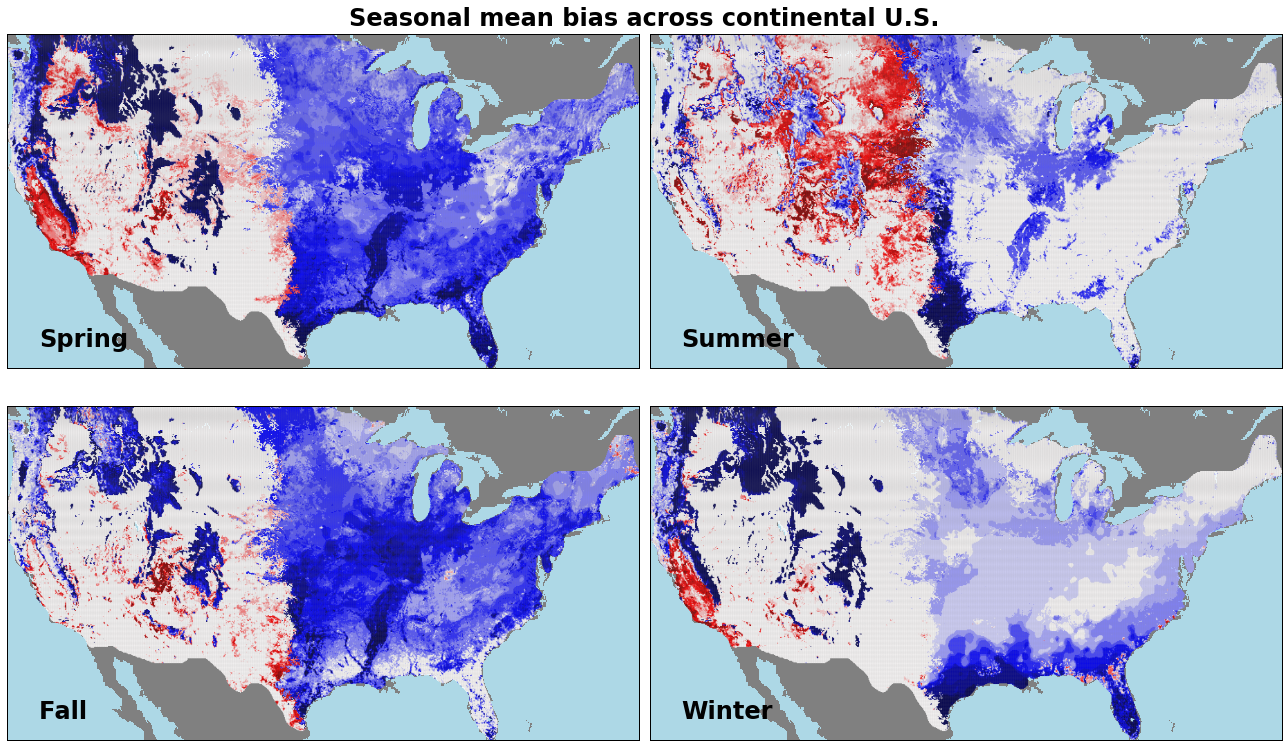

In [193]:
outdir='/home/ubuntu/dataset/output/'
seasons = {'Spring':[3, 4, 5], 'Summer':[6, 7, 8], 'Fall': [9, 10, 11], 'Winter': [12, 1, 2]}
cmap=mpl.cm.get_cmap('seismic')
norm = mpl.colors.Normalize(vmin=-1,vmax=1)
title = 'Seasonal mean bias across continental U.S.'

area_thresh=2500
land_color='grey'
ocean_color='lightblue'

fig = plt.figure(figsize=(18,11))
plt.suptitle(title, fontsize=24, fontweight='bold')
plt.axis('off')
for i, seas in enumerate(['Spring', 'Summer', 'Fall', 'Winter']):
    plt.subplot(2,2,i+1)
    
    y_diff = np.mean(df_diff_month[seasons[seas]].dropna().values, axis=1)
    lons, lats = zip(*df_diff_month[seasons[seas]].dropna().index.values)
    lons = np.array(lons)
    lats = np.array(lats)
    
    m = Basemap(projection='merc', llcrnrlat=lats.min(), llcrnrlon=lons.min(),
            urcrnrlat=lats.max(), urcrnrlon=lons.max(), resolution='f',
            area_thresh=area_thresh)
    xi, yi = m(lons, lats)
    m.scatter(xi, yi, c=y_diff, edgecolor='none', cmap=cmap, s=1, norm=norm)
    m.drawlsmask(land_color=land_color, ocean_color=ocean_color, lakes=True)
    ax = plt.gca()
    ax.text(0.05, 0.05, seas, weight='semibold', horizontalalignment='left',
            verticalalignment='bottom', transform=ax.transAxes, fontsize=24)
plt.tight_layout()

img_path = outdir+'classifier_avg_anomaly_per_season.png'
plt.savefig(img_path, bbox_inches='tight', dpi=300)
plt.show()



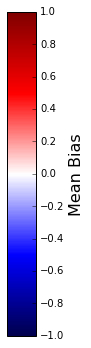

In [191]:
fig = plt.figure(figsize=(2, 5))
# using a linear colormap
ax1 = fig.add_axes([0.5, 0.1, 0.2, 0.9])
cbar = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='vertical')
cbar.set_label('Mean Bias', fontsize=16)
img_path = outdir+'classifier_avg_anomaly_per_season_cmap.png'
plt.savefig(img_path, bbox_inches='tight', dpi=300, transparent=True)

## For Regressor

In [219]:
# Loading saved models
modeldir = '/home/ubuntu/fall-foliage-finder/models/regressor/'
n_clusters = 8
models = {}
df_cluster = None

for cluster in xrange(n_clusters):
    json_file = modeldir+'model_architecture_'+str(cluster)+'.json'
    weights_file = modeldir+'model_weights_'+str(cluster)+'.h5'
    
    models[cluster] = model_from_json(open(json_file).read())
    models[cluster].load_weights(weights_file)
    models[cluster].compile(loss='mae', optimizer='adagrad')
    
    df_subset = pd.read_table(modeldir+'cluster_list_'+str(cluster)+'.txt',
                             delimiter=' ', names = ['xs', 'ys'])
    df_subset['cluster_num'] = np.ones(len(df_subset), dtype=int)*cluster
    df_cluster = pd.concat((df_cluster, df_subset))


# Loading weather data for training neural network 
folder = '/home/ubuntu/dataset/int_weather/'
nn = NN_Input(predict=2, history=2, box=5, random_seed=42)
nn.load_labels(folder+'all.ndvi.normed.nc', 'Band1')

# Recording the number of variables loaded. Later on each variable would get their own scaling factors
n_var = 4

f_paths = ['all.mean.of.Tmin.nc', 'all.mean.of.Tmin.nc' , 'all.min.of.Tmin.nc', 'all.min.of.Tmin.nc', 
           'all.sum.of.Prec.nc', 'all.sum.of.Prec.nc', 'all.max.of.Wind.nc', 'all.max.of.Wind.nc']
variables = ['Tmin', 'Tmin', 'Tmin', 'Tmin', 'Prec', 'Prec', 'Wind', 'Wind']
names = ['mean_tmin_history', 'mean_tmin_forecast', 'min_tmin_history', 'min_tmin_forecast',
         'sum_prec_history', 'sum_prec_forecast', 'max_wind_history', 'max_wind_forecast']
feature_types = ['history_time_series', 'forecast_time_series', 'history_time_series', 'forecast_time_series',
                'history_time_series', 'forecast_time_series', 'history_time_series', 'forecast_time_series']

for f_path, v, n, feature_type in zip(f_paths, variables, names, feature_types):
    nn.load_features(folder+f_path, v, n, feature_type)

In [220]:
# Loading scaling weights
df_scaling = pd.read_csv(modeldir+'scaling_weights.txt')

for i in xrange(n_var):
    df_scaling['mean'+str(i+1)] = df_scaling['mean'].apply(lambda x: float(x.split()[i]))
    df_scaling['std'+str(i+1)] = df_scaling['std'].apply(lambda x: float(x.split()[i]))

df_scaling = df_scaling.drop(['mean', 'std'], axis=1)
df_scaling.head()

,cluster,mean1,std1,mean2,std2,mean3,std3,mean4,std4
0,0,2.265198,5.557768,-0.301264,5.651538,36.610040,56.428476,4.092648,1.603309
1,1,11.868008,7.732751,7.728137,9.063829,25.618179,31.226213,4.150000,1.684984
2,2,-3.348122,8.125341,-6.882337,9.323530,13.442259,21.595304,3.642142,1.349635
3,3,2.274621,10.781825,-2.599504,11.594197,13.682416,19.247977,5.227614,1.640290
4,4,0.200921,8.845940,-3.876246,9.824845,6.387742,11.525064,4.421943,1.755659


/home/ubuntu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


for timepoint 20070413.5
for timepoint 20070421.5


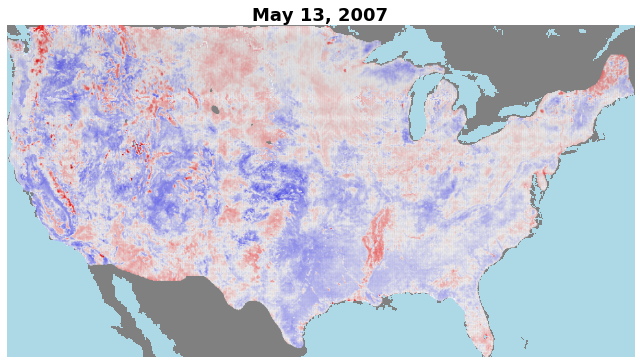

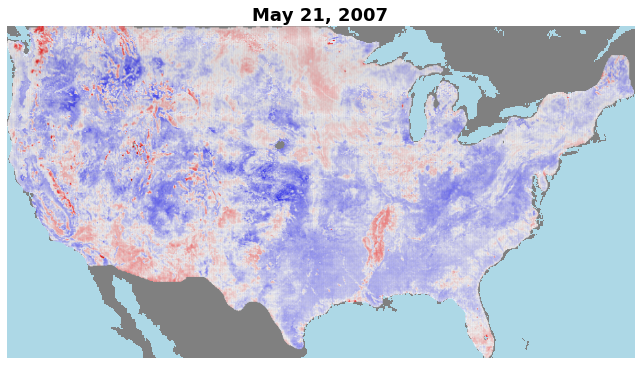

In [221]:
res = 0.0625/2
image_paths = []
total_output = {}


#for timepoint in xrange(-200, 0):
for timepoint in xrange(216, 218):
    
    ids, y_true, y_predict = [], [], []
    
    for cluster, model in models.iteritems():
        # print 'for cluster', cluster
        subset = df_cluster[df_cluster.cluster_num == cluster][['xs', 'ys']].values
        id_test, y_test, X_map_test = nn.select(t=timepoint, subset=subset)
        y_test = y_test.reshape(-1,1)
        
        n_layers = (X_map_test[0].shape[0])/n_var
        X_test = np.zeros(X_map_test.shape)

        for i in xrange(n_var):
            X_slice = X_map_test[:,i*n_layers:(i+1)*n_layers, :, :]
            X_test[:,i*n_layers:(i+1)*n_layers,:,:] = \
                scale_data(X_slice, df_scaling.iloc[cluster]['mean'+str(i+1)], df_scaling.iloc[cluster]['std'+str(i+1)])

        test_predict = model.predict(X_test)
        if ids == []:
            ids = id_test
            y_true = y_test
            y_predict = test_predict
        else:
            ids = np.vstack((ids, id_test))
            y_true = np.vstack((y_true, y_test))
            y_predict = np.vstack((y_predict, test_predict))
        
    timestamp = nn.times[(ids[0,0]).astype(int)]
    print 'for timepoint', timestamp
    xs = nn.lons[(ids[:,2]).astype(int)]
    ys = nn.lats[(ids[:,1]).astype(int)]
    
#     features=[]
#     for x, y, val_true, val_predict in zip(xs, ys, y_true, y_predict):
#         poly = Polygon([[(x-res, y-res), (x-res, y+res), (x+res, y+res), (x+res, y-res), (x-res, y-res)]])
#         true_class = int(val_true*10)
#         predict_class = int(val_predict*10)
#         features.append(Feature(geometry=poly, properties={"true": float(true_class), "predict": float(predict_class)}))        
#     fc = FeatureCollection(features)

#     with open(folder+'output/'+str(int(timestamp))+'.geojson', 'w') as outfile:
#         dump(fc, outfile)
        
    path = plot_diff_map(xs, ys, y_true, y_predict, timestamp=timestamp, 
                         s=1, outdir='/home/ubuntu/dataset/output/regressor/')
    image_paths.append(path)

#     index = pd.MultiIndex.from_tuples(list(zip(xs, ys)), names=['lon', 'lat'])
#     s = pd.Series((y_predict-y_true), index=index)
#     total_output[timestamp] = s
    

In [81]:
df_diff = pd.DataFrame(total_output)
df_diff = df_diff.T
df_diff['month'] = [int(str(x)[4:6]) for x in df_diff.index]
df_diff_month = df_diff.groupby('month').mean().T

In [ ]:
seasons = {'Spring':[3, 4, 5], 'Summer':[6, 7, 8], 'Fall': [9, 10, 11], 'Winter': [12, 1, 2]}
cmap=mpl.cm.get_cmap('seismic')
norm = mpl.colors.Normalize(vmin=-1.5,vmax=1.5)
title = 'Seasonal mean bias across continental U.S.'

area_thresh=2500
land_color='grey'
ocean_color='lightblue'

fig = plt.figure(figsize=(18,14))
plt.title(title, fontsize=18, fontweight='bold', loc='right')
plt.axis('off')
for i, seas in enumerate(seasons.keys()):
    plt.subplot(2,2,i+1)
    
    y_diff = np.mean(df_diff_month[seasons[seas]].values, axis=1)
    lons, lats = zip(*df_diff_month.index.values)
    
    m = Basemap(projection='merc', llcrnrlat=lats.min(), llcrnrlon=lons.min(),
            urcrnrlat=lats.max(), urcrnrlon=lons.max(), resolution='f',
            area_thresh=area_thresh)
    xi, yi = m(lons, lats)
    m.scatter(xi, yi, c=y_diff, edgecolor='none', cmap=cmap, s=s, norm=norm)
    m.drawlsmask(land_color=land_color, ocean_color=ocean_color, lakes=True)
plt.tight_layout()
plt.show()


img_path = outdir+'avg_anomaly_per_season.png'
plt.savefig(img_path, bbox_inches='tight', dpi=300)